## Solar burst on  2020.06.04  at  12:26:40 UTC   (15:26:40 UTC+3)

### GURT beam code according to UV-log at this time: 
#### UTC+3: 4/6/2020 15:26:15.004 U= A V= 4  #C9C5
### Which corresponds to codes: U = 01010 (0Ah, x = +6), V = 00100 (04h, y = +4), No 47 in PLT designation

### Import libraries

In [1]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import UnivariateSpline

### Reading the data from txt file

In [2]:
filename = 'DATA/A200604_105919.adr_12-26-30 - 12-27-10.txt'
file = open(filename, 'r')
param = []
for line in file:
    num = line.rstrip().split()
    floatnum = [float(i) for i in num]
    param.append(floatnum)
file.close()
param = np.array((param))
print ('  Shape of the array: ', param.shape)

  Shape of the array:  (2048, 400)


### Arranging time and frequency axis

In [3]:
f_min = 0.038                                                         # MHz
f_max = 78.125                                                        # MHz
n_channels = 2048
frequency = np.linspace(f_min, f_max, n_channels)                     # MHz
t_resolution = 0.1                                                    # Seconds
f_resolution = ((f_max - f_min) / n_channels) * 1000000
print(' Frequency resolution: ', f_resolution / 1000, ' kHz.')
print(' Frequency resolution: ', f_resolution, ' Hz.')
print('      Time resolution: ', t_resolution, ' s.')

 Frequency resolution:  38.12841796875  kHz.
 Frequency resolution:  38128.41796875  Hz.
      Time resolution:  0.1  s.


### Set channels to cut

In [4]:
low_cut_channel = 480
high_cut_channel = 1860
print('Min. frequency of the range: ', frequency[low_cut_channel], ' MHz')
print('Max. frequency of the range: ', frequency[high_cut_channel], ' MHz')

Min. frequency of the range:  18.34858133854421  MHz
Max. frequency of the range:  70.99150268685882  MHz


### Show the dynamic spectra of the burst with normalized frequency response

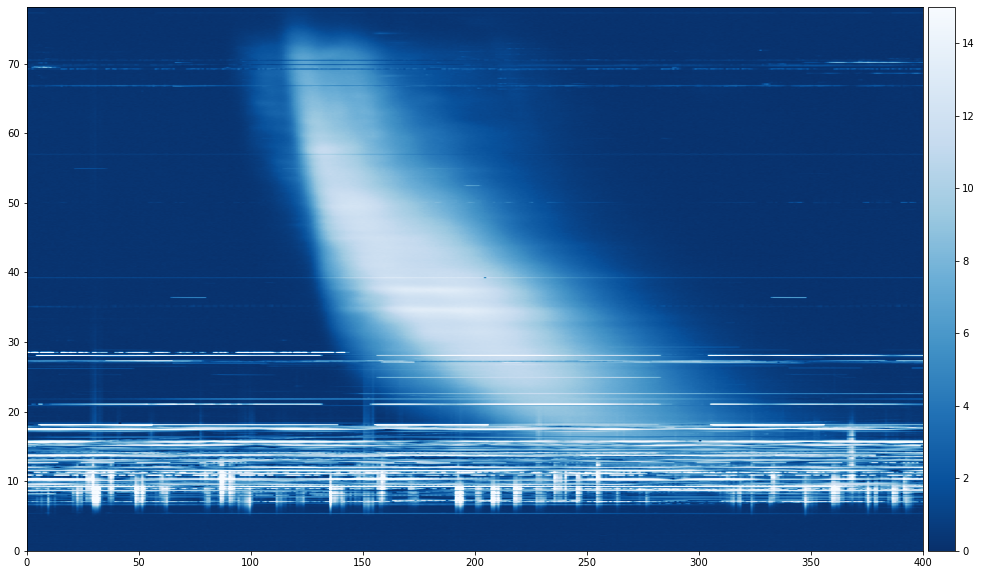

In [5]:
v_min = 0
v_max = 15
fig = plt.figure(figsize=(19.0, 10.0))
ax1 = fig.add_subplot(111)
im0 = ax1.imshow(np.flipud(param), aspect='auto', vmin=v_min, vmax=v_max, cmap='Blues_r', \
                  extent=[0, param.shape[1], 0, f_max])
cbar = fig.colorbar(im0, ax=ax1, pad=0.005)

#### Time profiles of the burst at various frequencies

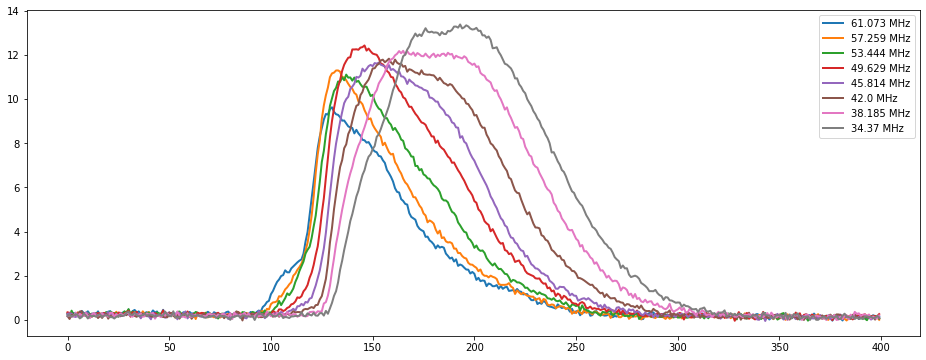

In [43]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.plot(param[1600, :], linewidth='2.0', label=str(np.round(frequency[1600], 3)) + ' MHz');
ax1.plot(param[1500, :], linewidth='2.0', label=str(np.round(frequency[1500], 3)) + ' MHz');
ax1.plot(param[1400, :], linewidth='2.0', label=str(np.round(frequency[1400], 3)) + ' MHz');
ax1.plot(param[1300, :], linewidth='2.0', label=str(np.round(frequency[1300], 3)) + ' MHz');
ax1.plot(param[1200, :], linewidth='2.0', label=str(np.round(frequency[1200], 3)) + ' MHz');
ax1.plot(param[1100, :], linewidth='2.0', label=str(np.round(frequency[1100], 3)) + ' MHz');
ax1.plot(param[1000, :], linewidth='2.0', label=str(np.round(frequency[1000], 3)) + ' MHz');
ax1.plot(param[900, :], linewidth='2.0', label=str(np.round(frequency[900], 3)) + ' MHz');
ax1.legend();
#ax1.set_xlim(xmin=0, xmax=78);

#### Time difference profile of the burst

In [7]:
diff_t = param.copy()
for i in range(diff_t.shape[1]-1):
    diff_t[:, i] = diff_t[:, i+1] - diff_t[:, i]

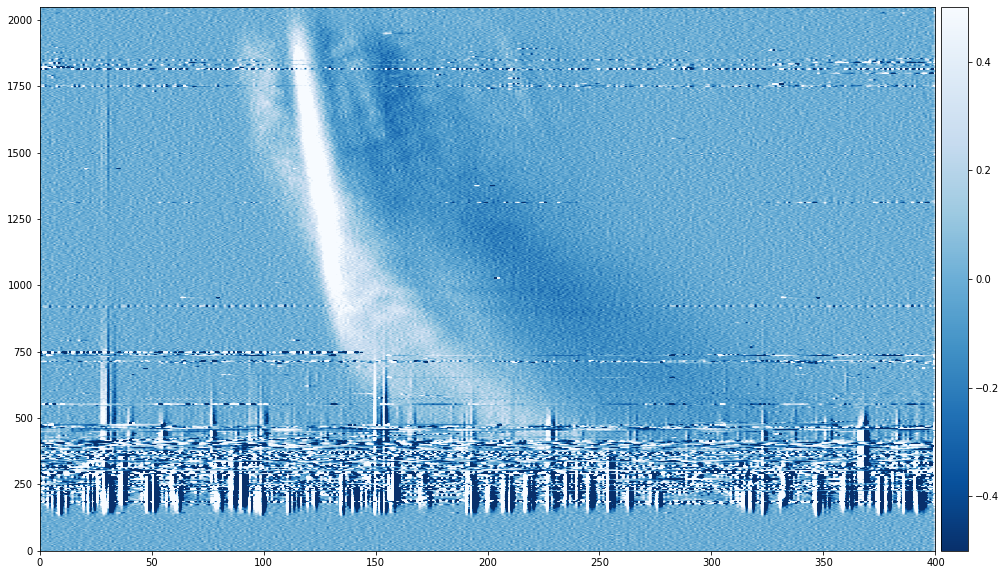

In [8]:
v_min = -0.5
v_max = 0.5
fig = plt.figure(figsize=(19.0, 10.0))
ax1 = fig.add_subplot(111)
im0 = ax1.imshow(np.flipud(diff_t), aspect='auto', vmin=v_min, vmax=v_max, cmap='Blues_r', \
                  extent=[0, diff_t.shape[1], 0, diff_t.shape[0]])
cbar = fig.colorbar(im0, ax=ax1, pad=0.005)

#### Frequency difference profile

In [9]:
diff_f = param.copy()
for i in range(diff_f.shape[0]-1):
    diff_f[i, :] = diff_f[i+1, :] - diff_f[i, :]

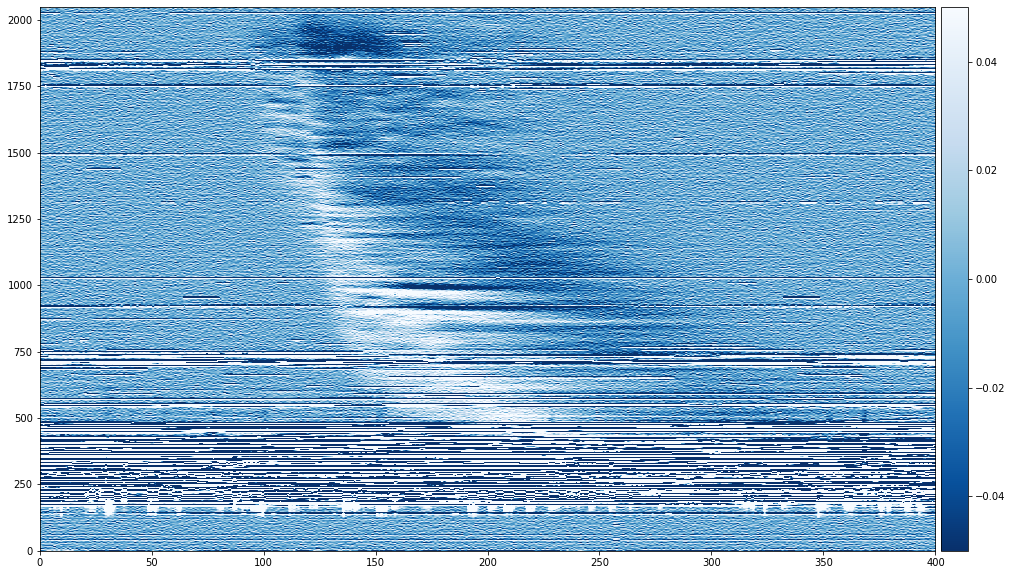

In [10]:
v_min = -0.05
v_max = 0.05
fig = plt.figure(figsize=(19.0, 10.0))
ax1 = fig.add_subplot(111)
im0 = ax1.imshow(np.flipud(diff_f), aspect='auto', vmin=v_min, vmax=v_max, cmap='Blues_r', \
                  extent=[0, diff_f.shape[1], 0, diff_f.shape[0]])
cbar = fig.colorbar(im0, ax=ax1, pad=0.005)

### Find the maximal data along time axis, in the areas free of RFI we assume that maximum corresponds to the maximum level of the burst

In [11]:
data = np.max(param, axis=1)

### Apply median filter to suppress the spikes from RFI

In [12]:
window_len = 40
fitered_data = ndimage.median_filter(data, size=window_len)

### The filtered responce (orange line) outside the area with strong RFI signals represents the maximal strength on the responce above the background

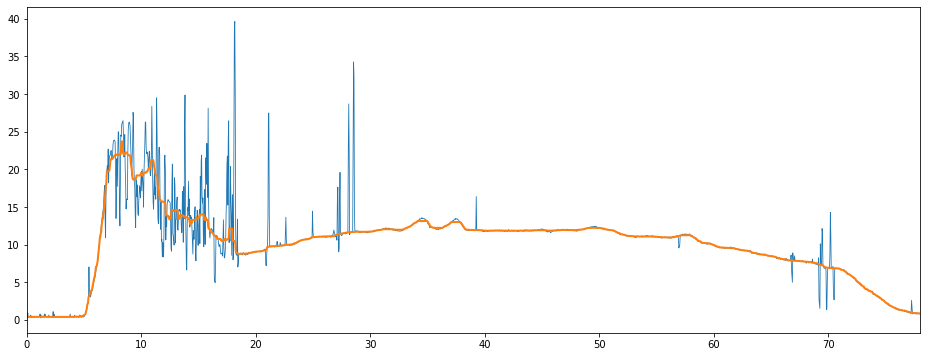

In [13]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.plot(frequency, data, linewidth='0.80');
ax1.plot(frequency, fitered_data, linewidth='2.0');
ax1.set_xlim(xmin=0, xmax=78);

### The same but filtered responce. Seems between 18 and 70 MHz (vertical red lines) we can suppose that this is the signal to noise ratio (SNR) of our signal, i.e. the rate the brightness temperature of the burst exceeds the temperature of the background noise (namely 9 dB at 18 MHz, 12 dB at 40 MHz and 6 dB at 70 MHz). 
### The responce at frequencies above 70 MHz we do no take into account as there is a strong effect of filters there. The responce below 18 MHz is the result of the RFI so we do not take into account either.

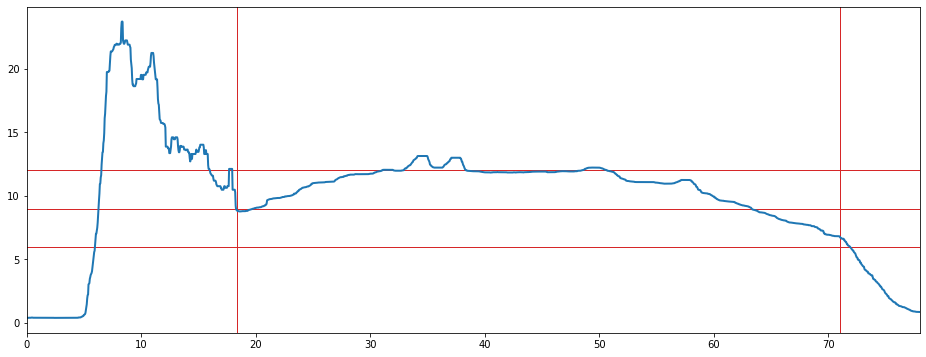

In [14]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.axvline(x=frequency[low_cut_channel], linewidth=1, color='C3');
ax1.axvline(x=frequency[high_cut_channel], linewidth=1, color='C3');
ax1.axhline(y=9, linewidth=1, color='C3');
ax1.axhline(y=12, linewidth=1, color='C3');
ax1.axhline(y=6, linewidth=1, color='C3');
ax1.plot(frequency, fitered_data, linewidth='2.0');
ax1.set_xlim(xmin=0, xmax=78);

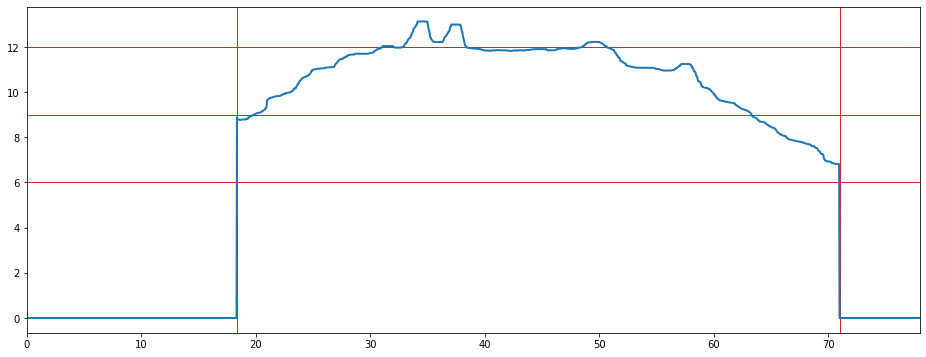

In [15]:
snr = fitered_data.copy();
snr[:low_cut_channel] = 0;
snr[high_cut_channel:] = 0;
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.axvline(x=frequency[low_cut_channel], linewidth=1, color='C3');
ax1.axvline(x=frequency[high_cut_channel], linewidth=1, color='C3');
ax1.axhline(y=9, linewidth=1, color='C3');
ax1.axhline(y=12, linewidth=1, color='C3');
ax1.axhline(y=6, linewidth=1, color='C3');
ax1.plot(frequency, snr, linewidth='2.0', color='C0');
ax1.set_xlim(xmin=0, xmax=78);

#### Conversion from dB to linear scale

In [16]:
snr = 10 ** (snr/10)
snr[:low_cut_channel] = 0;
snr[high_cut_channel:] = 0;

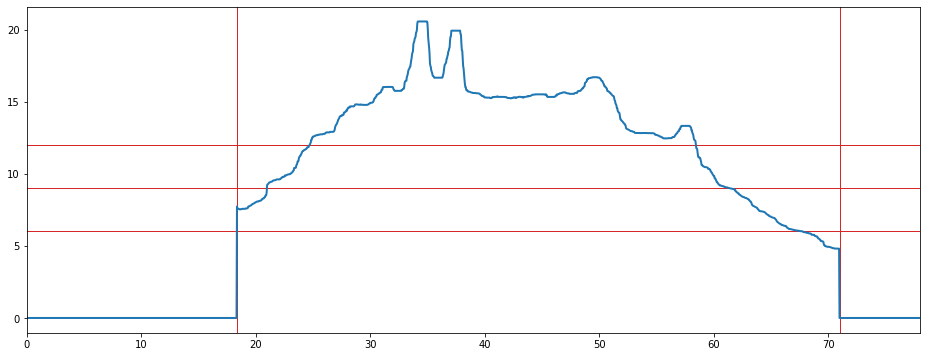

In [17]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.axvline(x=frequency[low_cut_channel], linewidth=1, color='C3');
ax1.axvline(x=frequency[high_cut_channel], linewidth=1, color='C3');
ax1.axhline(y=9, linewidth=1, color='C3');
ax1.axhline(y=12, linewidth=1, color='C3');
ax1.axhline(y=6, linewidth=1, color='C3');
ax1.plot(frequency, snr, linewidth='2.0', color='C0');
ax1.set_xlim(xmin=0, xmax=78);

### The basic relation for flux density calculation of the burst is:

$$
S = \left( 1 + \frac{1}{SND}\right) \cdot \frac{2 k_B T_{\text{bg}}}{A_{\text{eff}} \sqrt{\Delta t \cdot \Delta f}} \cdot SNR
$$


So we need to substitute all the values as accurate as we can find them to the relation. Let's try!

### Sky Noise Dominance (SND)

For GURT subarray we can assume that:
$$
SND = 10
$$
But we try to use the SND obrined from noise measurements (noise of short circuited amplifiers inputs and noise of connected dipoles to the amplifier inputs - sky noise)


#### Define a function that reads the noise levels from txt files

In [18]:
def read_frequency_and_two_values_txt(filename):
    file = open(filename, 'r')
    x_val = []
    y1_val = []
    y2_val = []
    for line in file:
        words = line.rstrip().split()
        x_val.append(float(words[0]))
        y1_val.append(float(words[1]))
        y2_val.append(float(words[2]))
    file.close()
    return x_val, y1_val, y2_val

#### Read noise levels to calculate SND

In [19]:
sky_noise_file = 'Data/Specter_A150521_114035_GURT_subarray_sky.txt'
short_noise_file = 'Data/Specter_A150521_102734_GURT_subarray_short.txt'

freq_noise, gurt_subarray_sky_noise, _ = read_frequency_and_two_values_txt(sky_noise_file)
freq_noise, gurt_subarray_shr_noise, _ = read_frequency_and_two_values_txt(short_noise_file)

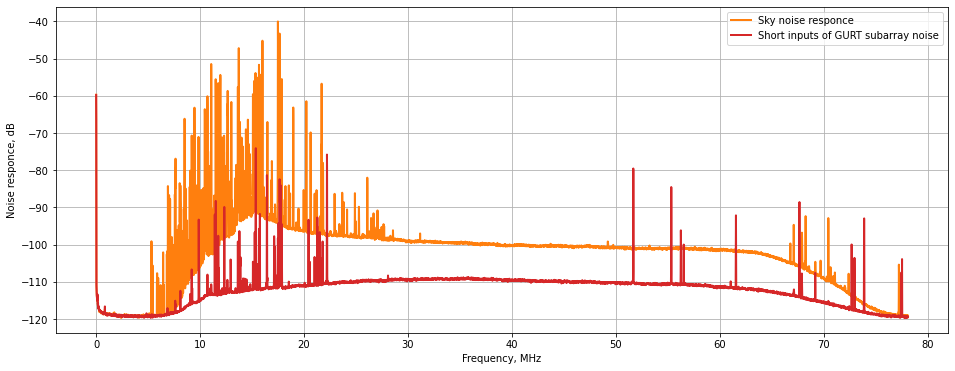

In [20]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.plot(freq_noise, gurt_subarray_sky_noise, linewidth='2.0', color='C1', label='Sky noise responce');
ax1.plot(freq_noise, gurt_subarray_shr_noise, linewidth='2.0', color='C3', label='Short inputs of GURT subarray noise');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Noise responce, dB');
ax1.grid('True')
ax1.legend();

#### Find minima among 32 channels to find the lower envelope of the noise responces

In [21]:
channels_to_min = 32
reduced_ch = int(len(gurt_subarray_sky_noise) / channels_to_min)
sky_noise_filtered = np.zeros(reduced_ch)
shr_noise_filtered = np.zeros(reduced_ch)

for i in range(reduced_ch):
    sky_noise_filtered[i] = np.min(gurt_subarray_sky_noise[i*channels_to_min:(i+1)*channels_to_min])
    shr_noise_filtered[i] = np.min(gurt_subarray_shr_noise[i*channels_to_min:(i+1)*channels_to_min])
    
freq_filtered = freq_noise[0::channels_to_min]
freq_filtered = freq_filtered[:-1]

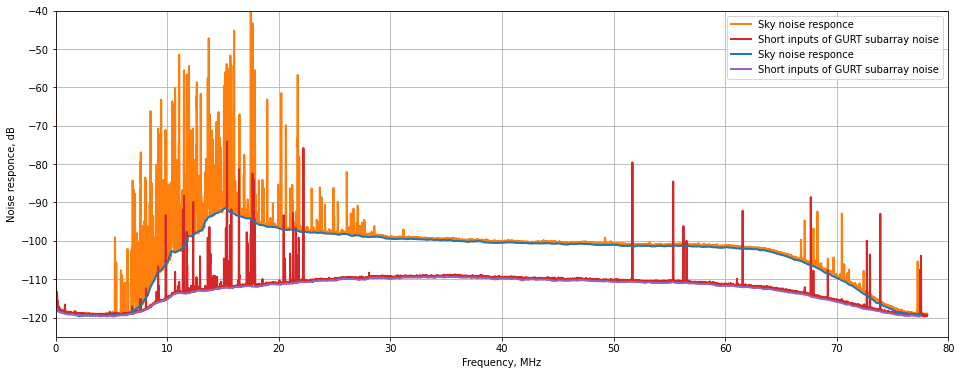

In [22]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.plot(freq_noise, gurt_subarray_sky_noise, linewidth='2.0', color='C1', label='Sky noise responce');
ax1.plot(freq_noise, gurt_subarray_shr_noise, linewidth='2.0', color='C3', label='Short inputs of GURT subarray noise');
ax1.plot(freq_filtered, sky_noise_filtered, linewidth='2.0', color='C0', label='Sky noise responce');
ax1.plot(freq_filtered, shr_noise_filtered, linewidth='2.0', color='C4', label='Short inputs of GURT subarray noise');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Noise responce, dB');
ax1.grid('True')
ax1.set_ylim(ymin=-125, ymax=-40);
ax1.set_xlim(xmin=0, xmax=80);
ax1.legend();

#### Calculating SND and apply median filter to it

In [23]:
snd_dB = sky_noise_filtered - shr_noise_filtered

window_len = 10
snd_dB = ndimage.median_filter(snd_dB, size=window_len)

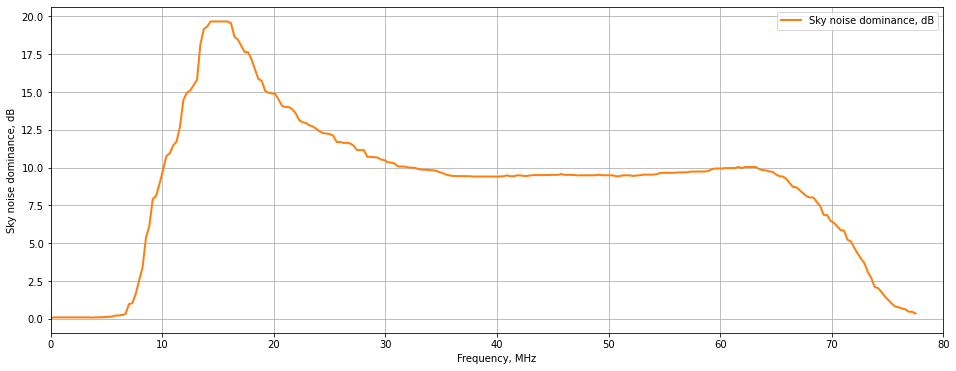

In [24]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.plot(freq_filtered, snd_dB, linewidth='2.0', color='C1', label='Sky noise dominance, dB');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Sky noise dominance, dB');
ax1.grid('True')
ax1.set_xlim(xmin=0, xmax=80);
ax1.legend();

#### Convert SND from dB to linear scale and interpolate it to common frequency scale

In [25]:
snd_0 = 10 ** (snd_dB/10)

interp_func = UnivariateSpline(freq_filtered, snd_0)
SND = interp_func(frequency)

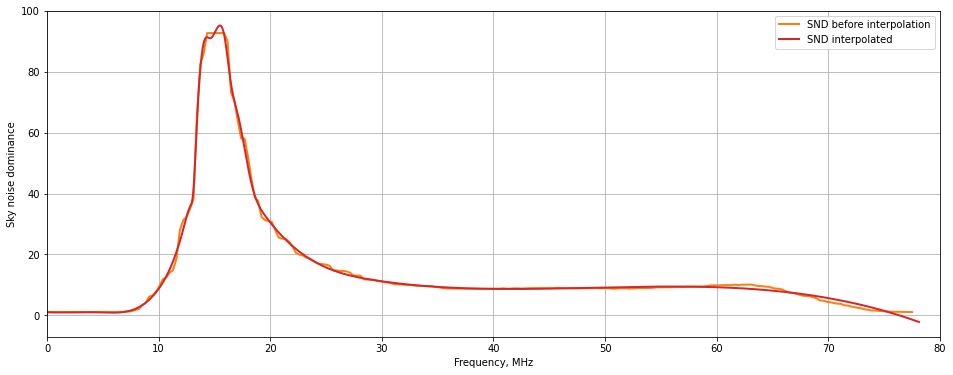

In [26]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.plot(freq_filtered, snd_0, linewidth='2.0', color='C1', label='SND before interpolation');
ax1.plot(frequency, SND, linewidth='2.0', color='C3', label='SND interpolated');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Sky noise dominance');
ax1.grid('True')
ax1.set_xlim(xmin=0, xmax=80);
ax1.legend();

### Boltzman's constant:

In [27]:
k_B = 1.38064852 * pow(10,-23)     # Boltzmann constant, W * m-2 * Hz-1 * sr-1

### (Can be improved) Sky background temperature (without particular direction) according to Krymkin:

In [28]:
T_bg = 3.78 * pow(10, 5) * pow((10 / frequency), 2.56)

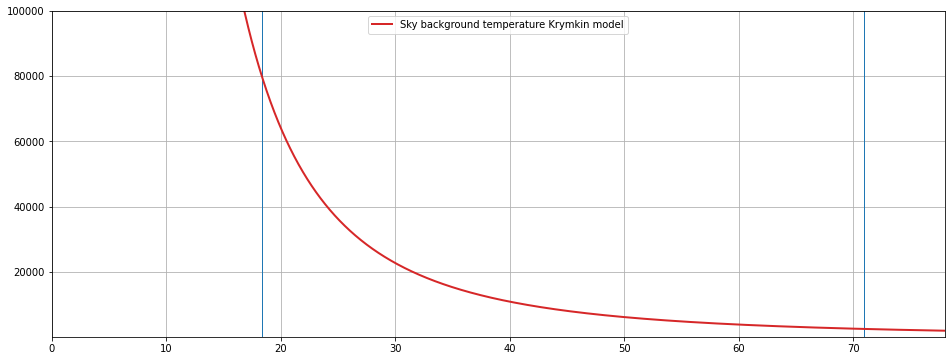

In [29]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.axvline(x=frequency[low_cut_channel], linewidth=1, color='C0');
ax1.axvline(x=frequency[high_cut_channel], linewidth=1, color='C0');
ax1.plot(frequency, T_bg, linewidth='2.0', color='C3', label='Sky background temperature Krymkin model');
ax1.legend();
ax1.grid('True')
plt.axis([0, 78, 100,  100000]);


### Effective area of the GURT subarray:

In [30]:
# A_eff = 250 # Old simple approxiamtion

#### Calculated (modeled) effective area for particular beam direction (GOST version) - table data on particular frequency points

In [31]:
f_Aeff = np.linspace(8.0, 80.0, 73) 
Aeff_calc_47 = np.array([1035,  931.6,  856.9,  795.9, 744.3, 700.3, 662.2, 628.4, 597.4, 568.8, 542.7, 519.1, 497.8, 478.8,\
                         461.9, 446.6, 432.7, 419.8, 407.6, 396.1, 385.3, 375.1, 365.6, 356.8,  348.5, 340.8, 333.5, 326.6, \
                         319.9, 313.5, 307.3, 301.4, 295.6,   290, 284.3, 278.4, 271.9, 264.6, 256.4, 247.2, 237.2,  226.3, \
                         214.7, 202.4, 189.6, 176.4, 163, 149.4, 135.9,   123,   111, 100.3, 91.49, 84.82, 80.11, 77.06, \
                         75.38, 74.75,  74.9, 75.68, 76.97, 78.64, 80.57, 82.69, 85.09,  87.8, 91.56, 98.07, 110.1, 133.7, \
                         147.9, 132.9, 119.3])

#### Interpolate the data to the frequency points of data

In [32]:
interp_func = UnivariateSpline(f_Aeff, Aeff_calc_47)
A_eff = interp_func(frequency)
A_eff[:low_cut_channel] = 0.0000001;
A_eff[high_cut_channel:] = 0.0000001;

#### Plot the initial and interpolated values of effective area 

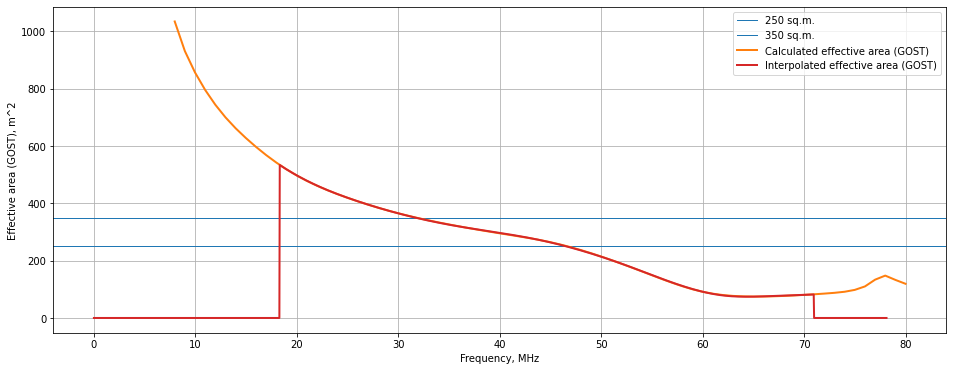

In [33]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.axhline(y=250, linewidth=1, color='C0', label='250 sq.m.');
ax1.axhline(y=350, linewidth=1, color='C0', label='350 sq.m.');
ax1.plot(f_Aeff, Aeff_calc_47, linewidth='2.0', color='C1', label='Calculated effective area (GOST)');
ax1.plot(frequency, A_eff, linewidth='2.0', color='C3', label='Interpolated effective area (GOST)');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Effective area (GOST), m^2');
ax1.grid('True')
ax1.legend();

### The estimation of the flux at GURT in Solar Flux Units (sfu):

Flux density
$$
S = \left( 1 + \frac{1}{SND}\right) \cdot \frac{2 k_B T_{\text{bg}}}{A_{\text{eff}} \sqrt{\Delta t \cdot \Delta f}} \cdot SNR
$$
Flux:
$$
F = \left( 1 + \frac{1}{SND}\right) \cdot \frac{2 k_B T_{\text{bg}}}{A_{\text{eff}}} \cdot SNR
$$


We use $10^{22}$ factor to obtain the flux in Solar Flux Units (sfu)

In [34]:
# flux_density_GURT_sfu = (1 + 1/SND) * T_bg * 2 * k_B * snr * pow(10, 22) / (A_eff * pow(t_resolution * f_resolution , 0.5)) 
flux_GURT_sfu = (1 + 1/SND) * T_bg * 2 * k_B * snr * pow(10, 22) / (A_eff) 

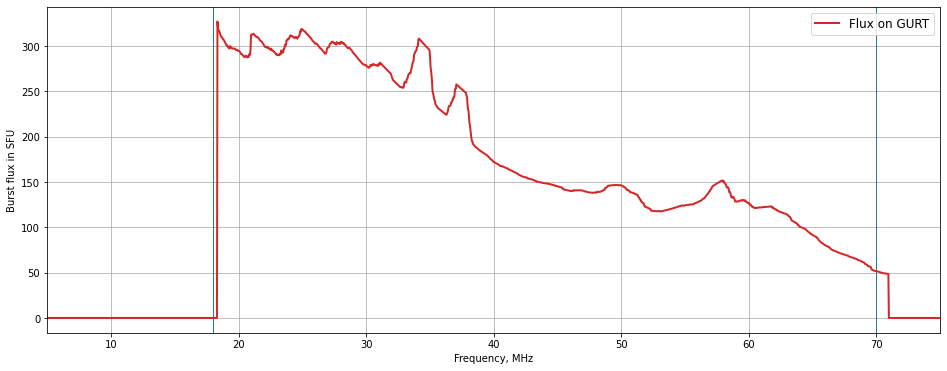

In [35]:
flux_GURT_sfu[:low_cut_channel] = 0
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.axvline(x=18, linewidth=1, color='C0');
ax1.axvline(x=70, linewidth=1, color='C0');
ax1.plot(frequency, flux_GURT_sfu, linewidth='2.0', color='C3', label='Flux on GURT');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Burst flux in SFU');
ax1.grid('True')
ax1.legend(loc="upper right", fontsize=12);
ax1.set_xlim(xmin=5, xmax=75);

### Solar flux measured at URAN-2

In [36]:
u2_freq = [32.77, 31.99, 30.96, 30.02, 28.99, 28.01, 26.98, 26, 25.02, 23.99, 23.01, 22.02, 20.99, 20.01, 18.98, 18, 16.97,\
           15.99, 15.01, 14.12, 13.44, 12.99, 12.45, 11.37, 11.02, 10.64, 10.05]
flux_URAN2_sfu = [58.3, 64.9, 58.3, 60.4, 64.9, 69.8, 86.6, 93.1, 96.5, 124.1, 148.6, 198.1, 220.7, 220.7, 220.7, 212.9, 228.8, 205.4,\
           228.8, 264.2, 294.3, 339.8, 365.2, 316.2, 273.8, 220.7, 245.8]

### Comparison of flux measurements

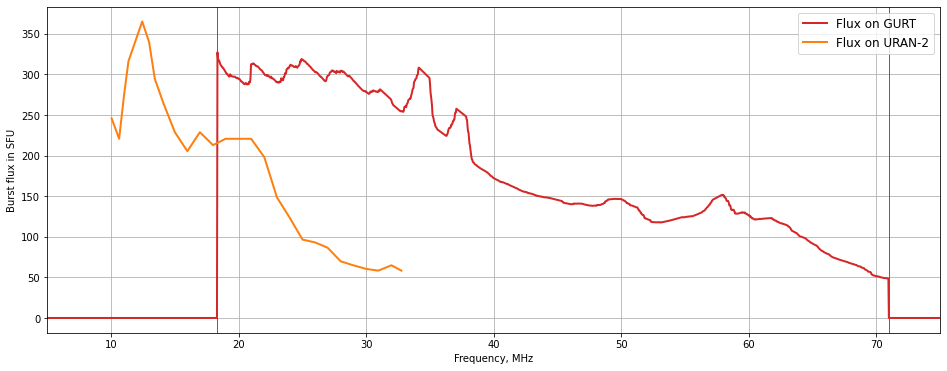

In [37]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.axvline(x=frequency[low_cut_channel], linewidth=1, color='C0');
ax1.axvline(x=frequency[high_cut_channel], linewidth=1, color='C0');
ax1.plot(frequency, flux_GURT_sfu, linewidth='2.0', color='C3', label='Flux on GURT');
ax1.plot(u2_freq, flux_URAN2_sfu, linewidth='2.0', color='C1', label='Flux on URAN-2');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Burst flux in SFU');
ax1.grid('True')
ax1.legend(loc="upper right", fontsize=12);
ax1.set_xlim(xmin=5, xmax=75);
fig.patch.set_facecolor('xkcd:white')
# pylab.savefig("Comparison of flux measurements.png", bbox_inches='tight', dpi=250)

#### Show just the essential data on the plot

In [38]:
frequency_last_pic = frequency[low_cut_channel:high_cut_channel];
flux_GURT_sfu_last_pic = flux_GURT_sfu[low_cut_channel:high_cut_channel];

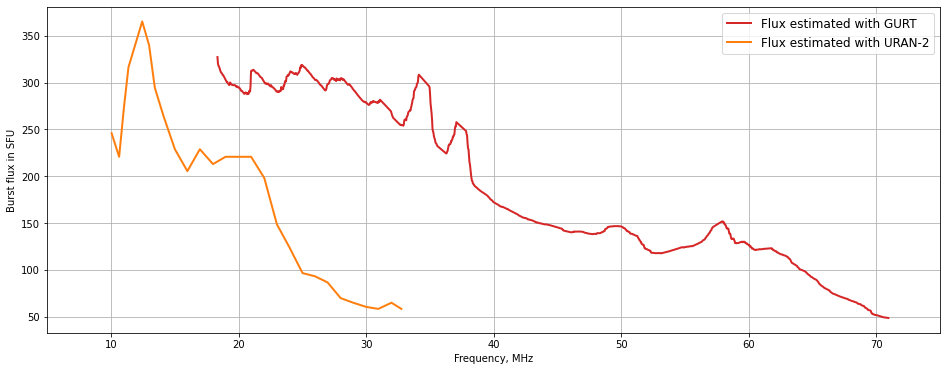

In [39]:
fig = plt.figure(figsize=(16.0, 6.0));
ax1 = fig.add_subplot(111);
ax1.plot(frequency_last_pic, flux_GURT_sfu_last_pic, linewidth='2.0', color='C3', label='Flux estimated with GURT');
ax1.plot(u2_freq, flux_URAN2_sfu, linewidth='2.0', color='C1', label='Flux estimated with URAN-2');
ax1.set_xlabel('Frequency, MHz');
ax1.set_ylabel('Burst flux in SFU');
ax1.grid('True')
ax1.legend(loc="upper right", fontsize=12);
ax1.set_xlim(xmin=5, xmax=75);
fig.patch.set_facecolor('xkcd:white')
# pylab.savefig("Comparison of flux measurements.png", bbox_inches='tight', dpi=250)